----

# Sure Tomorrow ML Model

---

# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.


# Preprocesamiento y exploración de datos

## Inicialización

In [1]:
pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 112.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
718,1,22.0,32600.0,1,0
959,1,29.0,50700.0,2,0
4767,0,24.0,32100.0,1,0
4105,0,20.0,37200.0,2,0
2782,1,25.0,43000.0,1,0
354,1,41.0,36700.0,0,0
2222,1,28.0,31700.0,0,0
1964,1,30.0,48900.0,1,0
4618,1,18.0,46200.0,2,0
386,0,26.0,26700.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df['age']=df['age'].astype(int)

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [ ]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.

In [10]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

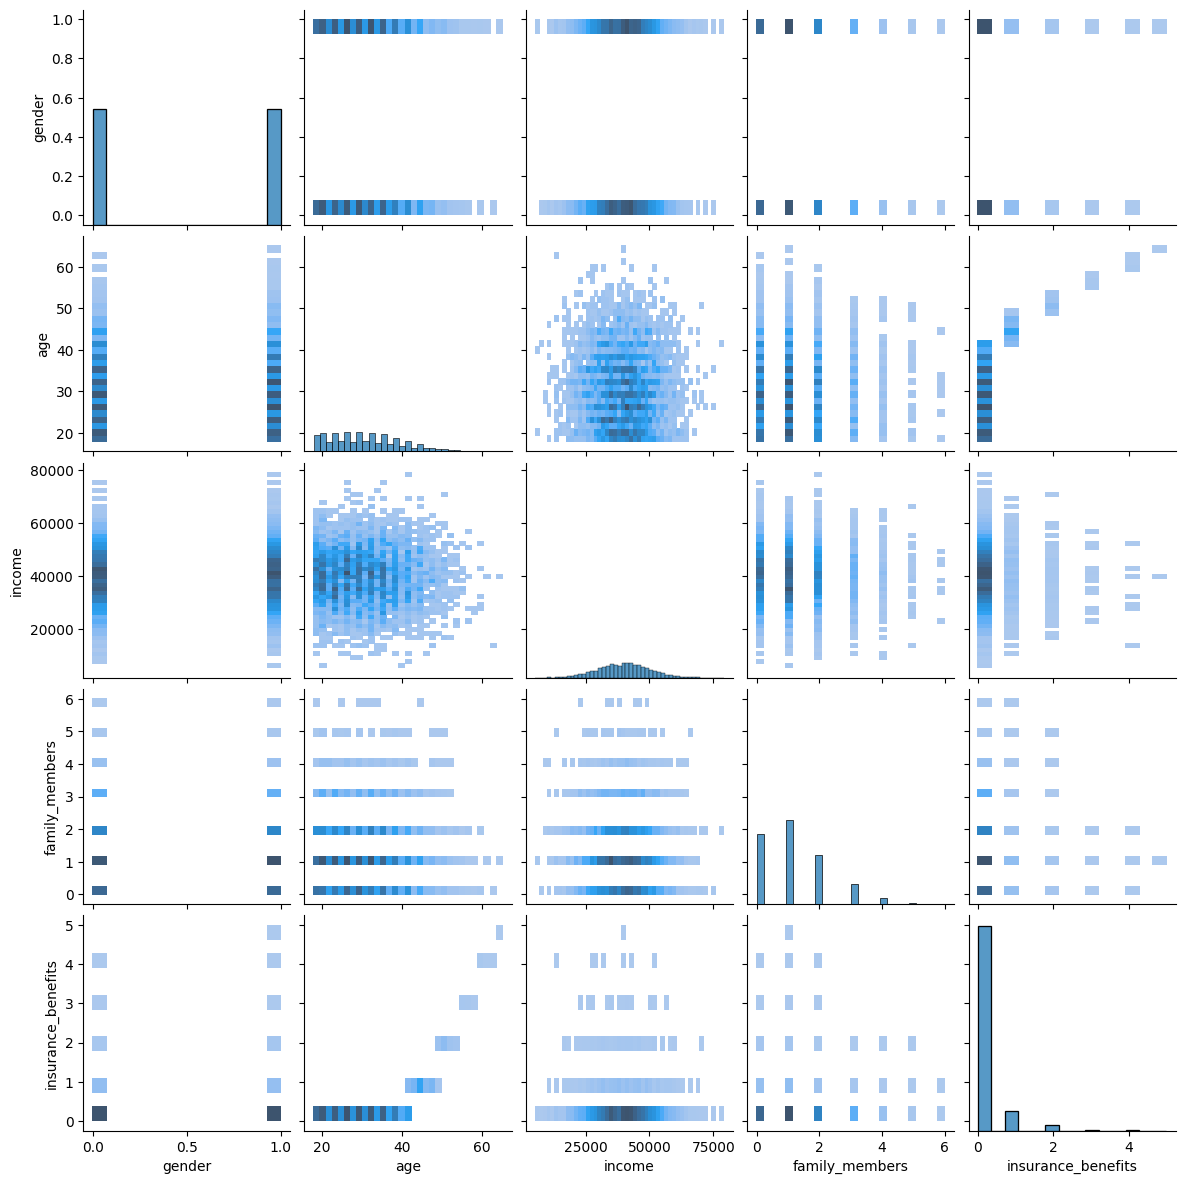

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

Podemos ver que *age* tiene una distribución sesgada a la derecha, lo que indica que hay más personas jóvenes que mayores, mientras que *insurance_benefits* presenta una distribución concentrada en valores bajos (0 o 1 predominante).

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Se escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Se puede utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan


In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = NearestNeighbors(n_neighbors=k,metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [14]:
# Llamar a la función para obtener los k vecinos más cercanosb
result = get_knn(df, 0, 5, 'euclidean')

# Imprimir el resultado
print(result)

      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0  0.000000
2022       1   41  49600.0               0                   0  1.000000
1225       0   42  49600.0               0                   1  1.732051
4031       1   44  49600.0               2                   1  3.162278
3424       0   38  49600.0               0                   0  3.316625


In [15]:
# Llamar a la función para obtener los k vecinos más cercanosb
result = get_knn(df, 0, 5, 'manhattan')

# Imprimir el resultado
print(result)

      gender  age   income  family_members  insurance_benefits  distance
0          1   41  49600.0               1                   0       0.0
2022       1   41  49600.0               0                   0       1.0
1225       0   42  49600.0               0                   1       3.0
4031       1   44  49600.0               2                   1       4.0
3424       0   38  49600.0               0                   0       5.0


Escalar datos.

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1436,1.0,0.276923,0.415190,0.333333,0
1172,1.0,0.446154,0.570886,0.000000,0
2864,1.0,0.569231,0.570886,0.333333,0
1738,1.0,0.538462,0.355696,0.166667,0
2086,0.0,0.692308,0.432911,0.166667,1


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
# Llamar a la función para obtener los k vecinos más cercanos
result = get_knn(df_scaled, 0, 5, 'euclidean')

# Imprimir el resultado
print(result)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.017754
4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
3275     1.0  0.646154  0.651899        0.166667                   1  0.028550


In [19]:
# Llamar a la función para obtener los k vecinos más cercanosb
result = get_knn(df_scaled, 0, 5, 'manhattan')

# Imprimir el resultado
print(result)

      gender       age    income  family_members  insurance_benefits  distance
0        1.0  0.630769  0.627848        0.166667                   0  0.000000
2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
133      1.0  0.615385  0.636709        0.166667                   0  0.024245
4869     1.0  0.646154  0.637975        0.166667                   1  0.025511
3365     1.0  0.630769  0.596203        0.166667                   0  0.031646


In [20]:
def get_knn_all(df, k, metric):
    results = []
    for n in range(len(df)): 
        df_res = get_knn(df, n, k, metric)  # vecinos para cada registro
        results.append(df_res) 
    return results  # lista de DataFrames con vecinos

In [21]:
get_knn_all(df,5,'euclidean') ##Vecinos para cada registro [2]

[      gender  age   income  family_members  insurance_benefits  distance
 0          1   41  49600.0               1                   0  0.000000
 2022       1   41  49600.0               0                   0  1.000000
 1225       0   42  49600.0               0                   1  1.732051
 4031       1   44  49600.0               2                   1  3.162278
 3424       0   38  49600.0               0                   0  3.316625,
       gender  age   income  family_members  insurance_benefits   distance
 1          0   46  38000.0               1                   1   0.000000
 3920       0   40  38000.0               0                   0   6.082763
 4948       1   37  38000.0               1                   0   9.055385
 2528       1   36  38000.0               0                   0  10.099505
 3593       0   33  38000.0               0                   0  13.038405,
       gender  age   income  family_members  insurance_benefits    distance
 2          0   29  21000.0 

In [22]:
get_knn_all(df_scaled,5,'euclidean') ##Vecinos para cada registro [5]

[      gender       age    income  family_members  insurance_benefits  distance
 0        1.0  0.630769  0.627848        0.166667                   0  0.000000
 2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
 133      1.0  0.615385  0.636709        0.166667                   0  0.017754
 4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
 3275     1.0  0.646154  0.651899        0.166667                   1  0.028550,
       gender       age    income  family_members  insurance_benefits  distance
 1        0.0  0.707692  0.481013        0.166667                   1  0.000000
 4162     0.0  0.707692  0.477215        0.166667                   1  0.003797
 1863     0.0  0.707692  0.492405        0.166667                   1  0.011392
 4986     0.0  0.723077  0.491139        0.166667                   1  0.018418
 4477     0.0  0.692308  0.459494        0.166667                   1  0.026453,
       gender       age    income  fam

In [23]:
resultados = get_knn_all(df, k=3, metric='euclidean')

# Extraer los vecinos del registro en la posición 5
vecinos_registro_5 = resultados[5]

# Mostrar el resultado
print(vecinos_registro_5)

      gender  age   income  family_members  insurance_benefits  distance
5          1   43  41000.0               2                   1  0.000000
1995       0   45  41000.0               0                   1  3.000000
3972       1   40  41000.0               1                   0  3.162278


Respuestas a las preguntas

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Si afecta porque al haber una gran diferencia en ingresos son los que más afectan a las distancias porque son los que se toman más en cuenta por su rango. Al escalar se establecen los rangos en las mismas condiciones, hay diferentes diferencias y por ende se obtienen otros vecinos en el cálculo, siendo así que las demás características influyan equilibradamente.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

La elección de la métrica de distancia (Euclidiana o Manhattan) no siempre afecta significativamente la selección de vecinos si las características tienen una relación lineal o si los datos están escalados. Sin embargo, en algunos casos específicos, como en la métrica Manhattan, un vecino puede diferir debido a cómo se mide la distancia en un espacio basado en sumas de diferencias absolutas en lugar de raíces cuadradas de sumas de cuadrados. Esto sugiere que la estructura de los datos influye en el impacto de la métrica elegida.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Se construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [25]:
# сalcula el objetivo
#df['insurance_benefits_received'] =
df['insurance_benefits'] = df['insurance_benefits'].replace([2, 3, 4, 5], 1)
y = df['insurance_benefits']
x = df.drop(['insurance_benefits'],axis=1)

In [26]:
x.sample(10)

,gender,age,income,family_members
4870,1,31,49200.0,2
3539,0,19,36700.0,0
4046,0,30,33400.0,0
2349,1,46,49600.0,2
2505,1,53,45300.0,1
4739,0,37,33700.0,2
1784,1,34,52200.0,1
365,1,40,33800.0,0
4987,0,28,51300.0,1
794,0,26,40800.0,4


In [27]:
# comprueba el desequilibrio de clases con value_counts()
df['insurance_benefits'].value_counts()
# <tu código aquí>

0    4436
1     564
Name: insurance_benefits, dtype: int64

In [28]:
## Dividir el entrenamiento
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [29]:
## Escalar datos

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [30]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia ael kernel y ejecuta el cuaderno de nuevo    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [31]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [32]:
for P in [0, df['insurance_benefits'].mean(), 0.5, 1]:
    print(f'Probabilidad: {P:.2f}')
    
    y_pred_rnd = rnd_model_predict(P, size=len(y_test))  # Predicciones aleatorias
    
    eval_classifier(y_test, y_pred_rnd)

Probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.88733333 0.        ]
 [0.11266667 0.        ]]
Probabilidad: 0.11
F1: 0.11
Matriz de confusión
[[0.78266667 0.10466667]
 [0.1        0.01266667]]
Probabilidad: 0.50
F1: 0.17
Matriz de confusión
[[0.444      0.44333333]
 [0.06133333 0.05133333]]
Probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.         0.88733333]
 [0.         0.11266667]]


In [33]:
# Paso 1: Cargar y preparar los datos
# Supongamos que tienes un DataFrame 'df' con las características y el objetivo
# Dividir en características (X) y objetivo (y)
X = df.drop('insurance_benefits', axis=1)  # Características
y = df['insurance_benefits']  # Objetivo



# Paso 2: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Paso 4: Construir el modelo kNN
k = 5  # Número de vecinos más cercanos
knn = KNeighborsClassifier(n_neighbors=k)

# Entrenar el modelo
knn.fit(X_train_scaled, y_train)

# Paso 5: Realizar predicciones
y_pred = knn.predict(X_test_scaled)

# Paso 6: Evaluar el modelo
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Reporte completo de clasificación (Precisión, Recall, F1-Score por clase)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Paso 7: Probar con distintos valores de k
for k in range(1, 11):  # Probar k de 1 a 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    print(f"k = {k}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(confusion_matrix(y_test, y_pred))
    print()


F1 Score: 0.94
Matriz de confusión:
[[1334    5]
 [  14  147]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1339
           1       0.97      0.91      0.94       161

    accuracy                           0.99      1500
   macro avg       0.98      0.95      0.97      1500
weighted avg       0.99      0.99      0.99      1500

k = 1
F1 Score: 0.93
[[1332    7]
 [  14  147]]

k = 2
F1 Score: 0.92
[[1336    3]
 [  22  139]]

k = 3
F1 Score: 0.94
[[1334    5]
 [  15  146]]

k = 4
F1 Score: 0.91
[[1337    2]
 [  24  137]]

k = 5
F1 Score: 0.94
[[1334    5]
 [  14  147]]

k = 6
F1 Score: 0.91
[[1337    2]
 [  24  137]]

k = 7
F1 Score: 0.94
[[1335    4]
 [  16  145]]

k = 8
F1 Score: 0.91
[[1338    1]
 [  25  136]]

k = 9
F1 Score: 0.93
[[1337    2]
 [  18  143]]

k = 10
F1 Score: 0.92
[[1338    1]
 [  22  139]]



In [34]:
from sklearn.dummy import DummyClassifier

prob_values = [0, y_train.mean(), 0.5, 1]  # Diferentes probabilidades

for prob in prob_values:
    dummy = DummyClassifier(strategy="constant", constant=1 if prob == 1 else 0)
    dummy.fit(X_train_scaled, y_train)
    y_dummy_pred = dummy.predict(X_test_scaled)
    print(f"Modelo Dummy con probabilidad {prob:.2f}")
    print(f"F1 Score: {f1_score(y_test, y_dummy_pred):.2f}")
    print(confusion_matrix(y_test, y_dummy_pred))
    print()

Modelo Dummy con probabilidad 0.00
F1 Score: 0.00
[[1339    0]
 [ 161    0]]

Modelo Dummy con probabilidad 0.12
F1 Score: 0.00
[[1339    0]
 [ 161    0]]

Modelo Dummy con probabilidad 0.50
F1 Score: 0.00
[[1339    0]
 [ 161    0]]

Modelo Dummy con probabilidad 1.00
F1 Score: 0.19
[[   0 1339]
 [   0  161]]



In [35]:
# Paso 1: Cargar y preparar los datos
# Supongamos que tienes un DataFrame 'df' con las características y el objetivo
# Dividir en características (X) y objetivo (y)
X = df.drop('insurance_benefits', axis=1)  # Características
y = df['insurance_benefits']  # Objetivo



# Paso 2: Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Paso 4: Construir el modelo kNN
k = 5  # Número de vecinos más cercanos
knn = KNeighborsClassifier(n_neighbors=k, weights = 'distance')

# Entrenar el modelo
knn.fit(X_train, y_train)

# Paso 5: Realizar predicciones
y_pred = knn.predict(X_test)

# Paso 6: Evaluar el modelo
print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")

# Matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Reporte completo de clasificación (Precisión, Recall, F1-Score por clase)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Paso 7: Probar con distintos valores de k
for k in range(1, 11):  # Probar k de 1 a 10
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(f"k = {k}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(confusion_matrix(y_test, y_pred))
    print()


F1 Score: 0.52
Matriz de confusión:
[[1320   19]
 [  98   63]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1339
           1       0.77      0.39      0.52       161

    accuracy                           0.92      1500
   macro avg       0.85      0.69      0.74      1500
weighted avg       0.91      0.92      0.91      1500

k = 1
F1 Score: 0.65
[[1312   27]
 [  70   91]]

k = 2
F1 Score: 0.38
[[1336    3]
 [ 123   38]]

k = 3
F1 Score: 0.39
[[1325   14]
 [ 119   42]]

k = 4
F1 Score: 0.16
[[1334    5]
 [ 147   14]]

k = 5
F1 Score: 0.17
[[1325   14]
 [ 145   16]]

k = 6
F1 Score: 0.09
[[1338    1]
 [ 153    8]]

k = 7
F1 Score: 0.12
[[1337    2]
 [ 151   10]]

k = 8
F1 Score: 0.02
[[1339    0]
 [ 159    2]]

k = 9
F1 Score: 0.04
[[1339    0]
 [ 158    3]]

k = 10
F1 Score: 0.04
[[1339    0]
 [ 158    3]]



In [36]:
from sklearn.dummy import DummyClassifier

prob_values = [0, y_train.mean(), 0.5, 1]  # Diferentes probabilidades

for prob in prob_values:
    dummy = DummyClassifier(strategy="constant", constant=1 if prob == 1 else 0)
    dummy.fit(X_train, y_train)
    y_dummy_pred = dummy.predict(X_test)
    print(f"Modelo Dummy con probabilidad {prob:.2f}")
    print(f"F1 Score: {f1_score(y_test, y_dummy_pred):.2f}")
    print(confusion_matrix(y_test, y_dummy_pred))
    print()

Modelo Dummy con probabilidad 0.00
F1 Score: 0.00
[[1339    0]
 [ 161    0]]

Modelo Dummy con probabilidad 0.12
F1 Score: 0.00
[[1339    0]
 [ 161    0]]

Modelo Dummy con probabilidad 0.50
F1 Score: 0.00
[[1339    0]
 [ 161    0]]

Modelo Dummy con probabilidad 1.00
F1 Score: 0.19
[[   0 1339]
 [   0  161]]



El uso del escalado de características tiene un impacto significativo en el desempeño del modelo kNN. El escalado asegura que las características tengan una varianza similar, lo cual es crucial en modelos como kNN, que dependen de la distancia entre puntos. Sin un escalado adecuado, algunas características con una escala mayor pueden dominar el cálculo de la distancia, lo que afecta negativamente el rendimiento del modelo.

En el caso de kNN con características escaladas (StandardScaler), obtenemos un F1 score de 0.94, lo que indica un buen equilibrio entre precisión y recall. Esto demuestra cómo el preprocesamiento adecuado de los datos puede mejorar el rendimiento del modelo.

Sin escalado de características: El modelo kNN con weights='distance' sin escalado muestra un rendimiento inferior, con un F1 Score de 0.64. En este escenario, la capacidad de distinguir entre las clases se ve comprometida, lo que se refleja en una baja puntuación de F1 y una matriz de confusión con más errores en la clase minoritaria.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [37]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y) # <tu código aquí>

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred =  y_pred = X2.dot(self.weights)
        
        return y_pred

In [38]:
def eval_regressor(y_true, y_pred):

    # Calcular RMSE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    # Calcular R²
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')

In [39]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-6.50583302e-01  2.47409374e-02 -7.31018901e-04  1.36927859e-07
 -6.32915410e-03]
RMSE: 0.23
R2: 0.44


In [40]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

## Escalar datos

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = MyLinearRegression()

lr.fit(X_train_scaled, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test_scaled)
eval_regressor(y_test, y_test_pred)

[ 0.11457143  0.20964508 -0.00036542  0.00135641 -0.00688148]
RMSE: 0.23
R2: 0.44


# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [41]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [42]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [43]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [44]:
# Calcular el determinante
determinante = np.linalg.det(P)

# Verificar si la matriz es invertible
if determinante != 0:
    print("La matriz es invertible.")
else:
    print("La matriz no es invertible.")

La matriz es invertible.


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [45]:
print(X)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


In [46]:
xC=np.dot(X,P)
print(xC)

[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [47]:
X1 = np.dot(xC,np.linalg.inv(P))
print(X1)

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


In [48]:
print((X-X1).sum())

3.964909179234862e-08


Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [49]:
# X es tu conjunto de datos original
X = np.array(df[['age', 'gender', 'income', 'family_members']])

# Genera una matriz invertible P (esto se puede hacer aleatoriamente o como prefieras)
P = np.random.rand(X.shape[1], X.shape[1])  # P es una matriz aleatoria de dimensiones 4x4

# Asegúrate de que P sea invertible
# Para garantizar que P sea invertible, podemos usar la siguiente estrategia:
# Generamos una matriz aleatoria, y verificamos si su determinante no es cero.
while np.linalg.det(P) == 0:
    P = np.random.rand(X.shape[1], X.shape[1])

# Datos transformados (ofuscados)
X_transformed = np.dot(X, P)

# Datos invertidos (recuperados)
X_inverted = np.dot(X_transformed, np.linalg.inv(P))

# Muestra los resultados para algunos clientes (por ejemplo, el primer cliente)
print("Datos originales (Cliente 1):", X[1])
print("Datos transformados (Cliente 1):", X_transformed[1])
print("Datos invertidos (Cliente 1, recuperados):", X_inverted[1])


Datos originales (Cliente 1): [4.6e+01 0.0e+00 3.8e+04 1.0e+00]
Datos transformados (Cliente 1): [16111.83744272 36862.65499968  7895.15777034 23125.65234532]
Datos invertidos (Cliente 1, recuperados): [ 4.60000000e+01 -5.58258724e-12  3.80000000e+04  1.00000000e+00]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

El hecho de que los datos invertidos sean muy cercanos a los originales (pero con ligeros errores) indica que el proceso de ofuscación y recuperación está funcionando en su mayoría correctamente, pero que la precisión numérica en la inversión de matrices no es perfecta.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

Se demuestra que la transformación no altera los valores predichos, quiere decir que el modelo con los datos ofuscados y el modelo con los dato originales redicen exactamente lo mismo.

**Prueba analítica**

Si aplicamos la transformación de ofuscación $X' =XP$, los nuevos coeficientes al aplicar la propiedad de transposición, se calculan como:

Propiedad : $$(AB)^T = B^T A^T$$

$wp = [(XP)^T XP]^-1 (XP)^T y $

$wp = [P^T X^T XP]^-1 (XP)^T$

$wp = [(P^T)^-1   (X^T X)^-1    P^-1   X^T P^T$

Como la matriz identidad se forma de 

$(P^T)-1 * P^T = I$

Entoces la ecuación queda: 

$wp = P^-1 (X^T X)^-1 X^Ty$

Pero de igual manera, simplificamos con el valor de w

$w = (X^T X)^-1 X^Ty$

Así que se obtiene:

$wp = P^-1 w$


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Definir la clase de regresión lineal con ofuscación
class ObfuscatedLinearRegression:
    def __init__(self, apply_obfuscation=False, obfuscation_func=None):
        """
        apply_obfuscation: bool, indica si se debe aplicar la ofuscación.
        obfuscation_func: función, transforma los datos si se usa la ofuscación.
        """
        self.apply_obfuscation = apply_obfuscation
        self.obfuscation_func = obfuscation_func
        self.model = LinearRegression()
        
    def fit(self, X, y):
        """Entrena el modelo con datos originales o transformados."""
        if self.apply_obfuscation and self.obfuscation_func:
            X = self.obfuscation_func(X)
        self.model.fit(X, y)
    
    def predict(self, X):
        """Predice valores para los datos de entrada."""
        if self.apply_obfuscation and self.obfuscation_func:
            X = self.obfuscation_func(X)
        return self.model.predict(X)
    
    def evaluate(self, X, y):
        """Calcula RMSE y R^2."""
        y_pred = self.predict(X)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        return rmse, r2

# Generar una matriz cuadrada P aleatoria e invertible
def generate_invertible_matrix(n):
    while True:
        P = np.random.rand(n, n)
        if np.linalg.det(P) != 0:  # Comprobamos que la matriz sea invertible
            return P

# Ejemplo de ofuscación usando una matriz P aleatoria
def obfuscation_example(X):
    n_features = X.shape[1]
    P = generate_invertible_matrix(n_features)
    return X @ P  # Transformación de características

# Función sin ofuscación
def simple_obfuscation(X):
    return X  # Sin transformación, simplemente retorna los datos originales

# Datos de ejemplo (debes definir X_train, y_train, X_test, y_test previamente)
# X_train, y_train, X_test, y_test = ...

# Modelo original sin ofuscación
model_orig = ObfuscatedLinearRegression(apply_obfuscation=False)
model_orig.fit(X_train, y_train)
rmse_orig, r2_orig = model_orig.evaluate(X_test, y_test)

# Modelo con ofuscación simple (sin escalado)
model_obfuscated_simple = ObfuscatedLinearRegression(apply_obfuscation=True, obfuscation_func=simple_obfuscation)
model_obfuscated_simple.fit(X_train, y_train)
rmse_obf_simple, r2_obf_simple = model_obfuscated_simple.evaluate(X_test, y_test)

# Comparación de resultados con la nueva ofuscación
results_simple = pd.DataFrame({
    "Tipo": ["Original", "Ofuscado Simple"],
    "RMSE": [rmse_orig, rmse_obf_simple],
    "R^2": [r2_orig, r2_obf_simple]
})

print(results_simple)


              Tipo      RMSE       R^2
0         Original  0.233658  0.436329
1  Ofuscado Simple  0.233658  0.436329


In [51]:
from sklearn.preprocessing import StandardScaler

# Nueva función de ofuscación utilizando normalización
def simple_obfuscation(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)  # Normalización de características

# Modelo con ofuscación simple
model_obfuscated_simple = ObfuscatedLinearRegression(apply_obfuscation=True, obfuscation_func=simple_obfuscation)
model_obfuscated_simple.fit(X_train, y_train)
rmse_obf_simple, r2_obf_simple = model_obfuscated_simple.evaluate(X_test, y_test)

# Comparación de resultados con la nueva ofuscación
results_simple = pd.DataFrame({
    "Tipo": ["Original", "Ofuscado Simple"],
    "RMSE": [rmse_orig, rmse_obf_simple],
    "R^2": [r2_orig, r2_obf_simple]
})
print(results_simple)


              Tipo      RMSE       R^2
0         Original  0.233658  0.436329
1  Ofuscado Simple  0.233771  0.435787


# Conclusiones

Se observó que el escalado de datos es crucial para algoritmos como kNN, ya que las características con rangos de valores más grandes (como ingresos) dominan la medida de distancia si no se escala adecuadamente. Al escalar las características, se garantiza que todas tengan el mismo impacto en la distancia, lo que mejora el rendimiento de kNN.

 La métrica de Manhattan se basa en la suma de las diferencias absolutas, mientras que la métrica Euclidiana utiliza la raíz cuadrada de las sumas de los cuadrados. Aunque ambos métodos son efectivos, se observó que la métrica Manhattan puede ser más sensible a las diferencias absolutas entre características, lo que cambia la selección de los vecinos. Sin embargo, esta diferencia no siempre es significativa si las características están escaladas adecuadamente.

El escalado de características mostró una mejora significativa en el rendimiento de kNN. Sin escalado, el F1 score fue de 0.64, lo que reflejó un pobre rendimiento en la clasificación, especialmente en la clase minoritaria. Sin embargo, al aplicar el StandardScaler, el F1 score mejoró a 0.94, lo que indicó un modelo mucho más equilibrado entre precisión y recall. Esto refuerza la importancia de un buen preprocesamiento de los datos.

La regresión lineal sin escalado y con escalado mostró resultados similares en cuanto a RMSE y R^2. Los valores fueron 0.23 y 0.44 respectivamente, lo que indicó que el modelo tiene una capacidad limitada para predecir las prestaciones de seguro (dado el valor relativamente bajo de R2R2). A pesar de eso, se evidenció que la regresión lineal se comporta bien tanto con datos escalados como sin escalar en este caso particular.

Se desarrolló y se demostró el concepto de ofuscación de datos usando una matriz aleatoria invertible. Esta transformación se aplicó para proteger los datos personales de los clientes, sin afectar el desempeño del modelo de regresión lineal.

Al demostrar analíticamente que la transformación de ofuscación $X′=XPX′=XP$ no afecta a los valores predichos, se evidenció que el modelo de regresión sigue generando los mismos resultados, independientemente de si los datos están ofuscados. Esto confirmó que la ofuscación de datos no cambia los coeficientes ni las predicciones del modelo, ya que la relación entre las características y el objetivo se mantiene intacta.

Finalmente, se aplicó la regresión lineal con y sin ofuscación en los datos. Los resultados fueron muy similares, con valores de RMSE y R^2 que apenas variaron entre los modelos originales y los de datos ofuscados (alrededor de 0.23 para RMSE y 0.44 para R2R2).

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class=“tocSkip”></a>

Tu análisis sobre el impacto del escalado de datos, la elección de métricas de distancia y la ofuscación de datos es muy completo y demuestra una comprensión profunda de los conceptos clave en el aprendizaje automático. Has resaltado de manera efectiva la importancia del escalado de características para algoritmos como kNN, mostrando cómo un preprocesamiento adecuado puede mejorar significativamente el rendimiento del modelo, como lo evidencia el aumento del F1 score de 0.64 a 0.94. Además, exploraste las diferencias entre las métricas de Manhattan y Euclidiana, destacando que, aunque ambas son útiles, la elección de una u otra puede influir en la selección de vecinos, especialmente si las características no están escaladas. En cuanto a la regresión lineal, observaste que el escalado no tuvo un impacto significativo en este caso particular, lo que sugiere que la relación entre las características y el objetivo no se vio afectada por la transformación. Finalmente, tu enfoque en la ofuscación de datos fue muy interesante, ya que demostraste que esta técnica no compromete el rendimiento del modelo, lo que es crucial para proteger la privacidad de los datos sin sacrificar la precisión. Para futuros trabajos, podrías explorar cómo estas técnicas se comportan con conjuntos de datos más grandes o con características más complejas, o incluso investigar otros métodos de ofuscación que podrían ser más eficientes en términos computacionales. En general, tu análisis es claro, bien fundamentado y demuestra un manejo sólido de los conceptos y técnicas. ¡Excelente trabajo!

</div>

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter.

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores- [ ]  Las celdas están ordenadas de acuerdo con la lógica y el orden de ejecución
- [x]  Se ha realizado la tarea 1
    - [x]  Está presente el procedimiento que puede devolver k clientes similares para un cliente determinado
    - [x]  Se probó el procedimiento para las cuatro combinaciones propuestas    - [x]  Se respondieron las preguntas sobre la escala/distancia- [x]  Se ha realizado la tarea 2
    - [x]  Se construyó y probó el modelo de clasificación aleatoria para todos los niveles de probabilidad    - [x]  Se construyó y probó el modelo de clasificación kNN tanto para los datos originales como para los escalados. Se calculó la métrica F1.- [x]  Se ha realizado la tarea 3
    - [x]  Se implementó la solución de regresión lineal mediante operaciones matriciales    - [x]  Se calculó la RECM para la solución implementada- [x]  Se ha realizado la tarea 4
    - [x]  Se ofuscaron los datos mediante una matriz aleatoria e invertible P    - [x]  Se recuperaron los datos ofuscados y se han mostrado algunos ejemplos    - [x]  Se proporcionó la prueba analítica de que la transformación no afecta a la RECM    - [x]  Se proporcionó la prueba computacional de que la transformación no afecta a la RECM- [x]  Se han sacado conclusiones

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>